In [26]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
import random as ran
from IPython.display import clear_output
from src import spotify, dp, utils, DB
from sklearn.metrics.pairwise import euclidean_distances as euc
import pandas as pd
import math as mt
import numpy as np
import matplotlib.pyplot as plt

db = DB()

In [189]:
ms = utils.MatchingSystem()

# K Checking
- 새로운 K의 갯수를 만들 수 있는지 확인하는 과정

In [190]:
ms.check()

현재 seed 음악 갯수 : 334
K 갯수 : 13 (후에 체크 방식으로 진행)


# KMeans Run

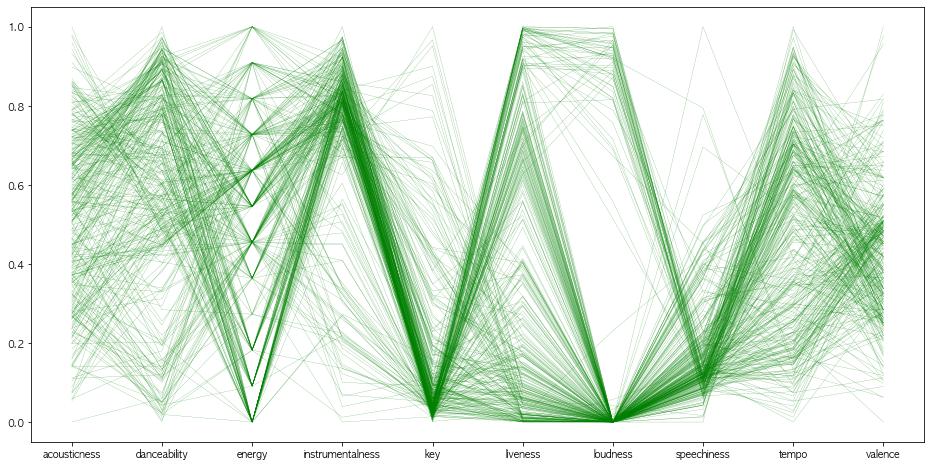

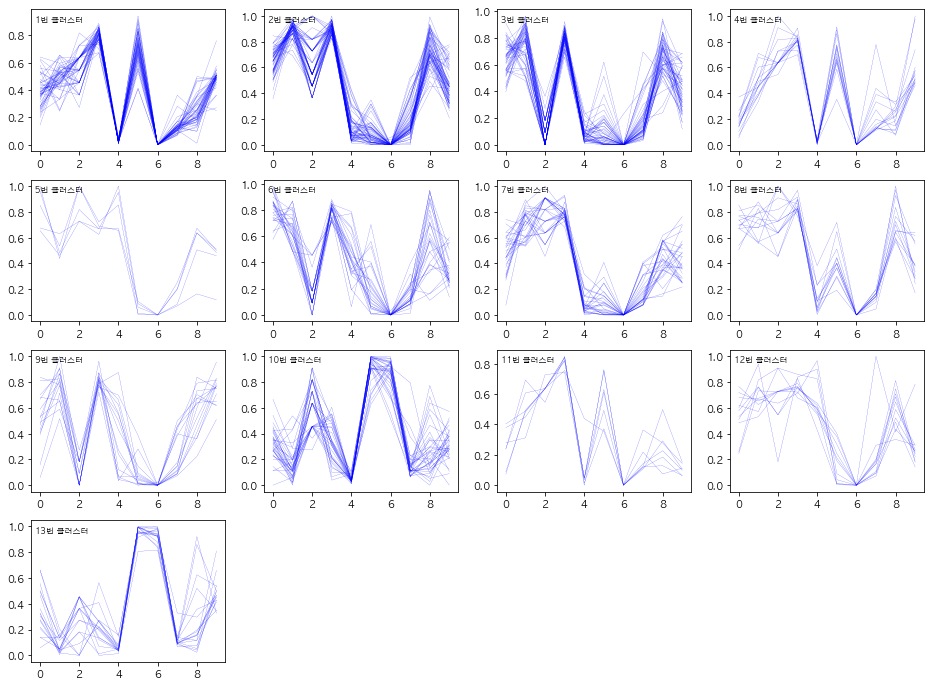

In [215]:
ms.kmeans_run()

clear_output(wait=True)

norm_features = ms.norm_features
kmeans = ms.kmeans

utils.visual_norm_data(None, norm_features)
utils.visual_cluster_data(norm_features, kmeans)

# Mail Box Matching

In [216]:
ms.box_matching()

ms.mail_box_radar.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
623f2515ff1c441a392ab38c,0,0,0,0,0,0,0,0,0,0,0,0,100
623f2515ff1c441a392ab38d,75,6,0,19,0,0,0,0,0,0,0,0,0
623f2515ff1c441a392ab38e,50,0,0,0,0,0,0,0,0,45,0,0,5
623f2515ff1c441a392ab38f,56,17,0,28,0,0,0,0,0,0,0,0,0
623f2515ff1c441a392ab390,0,14,0,0,57,14,0,0,0,0,0,14,0


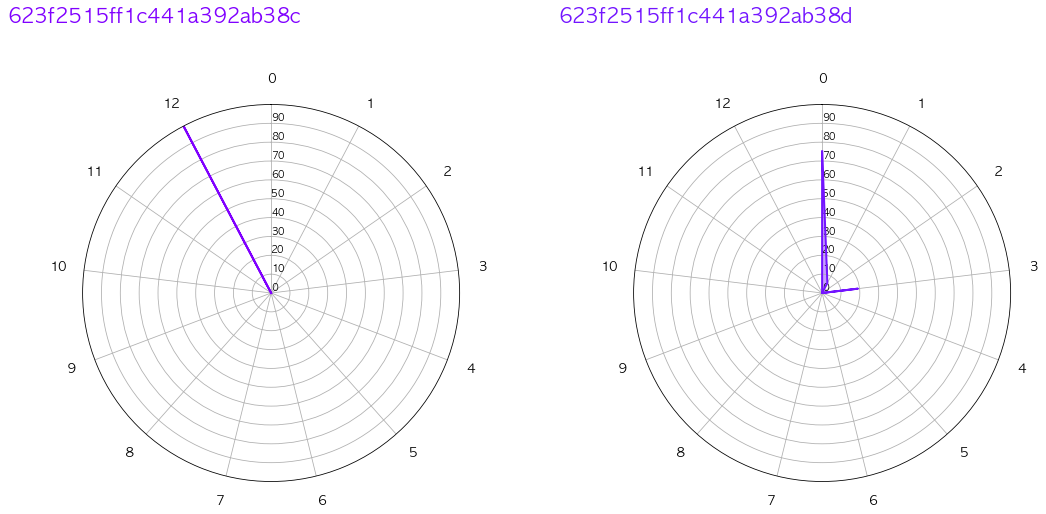

계속 진행하시려면 next, 종료는 아무거나 입력해주세요.


In [217]:
ms.visual_radar_step()

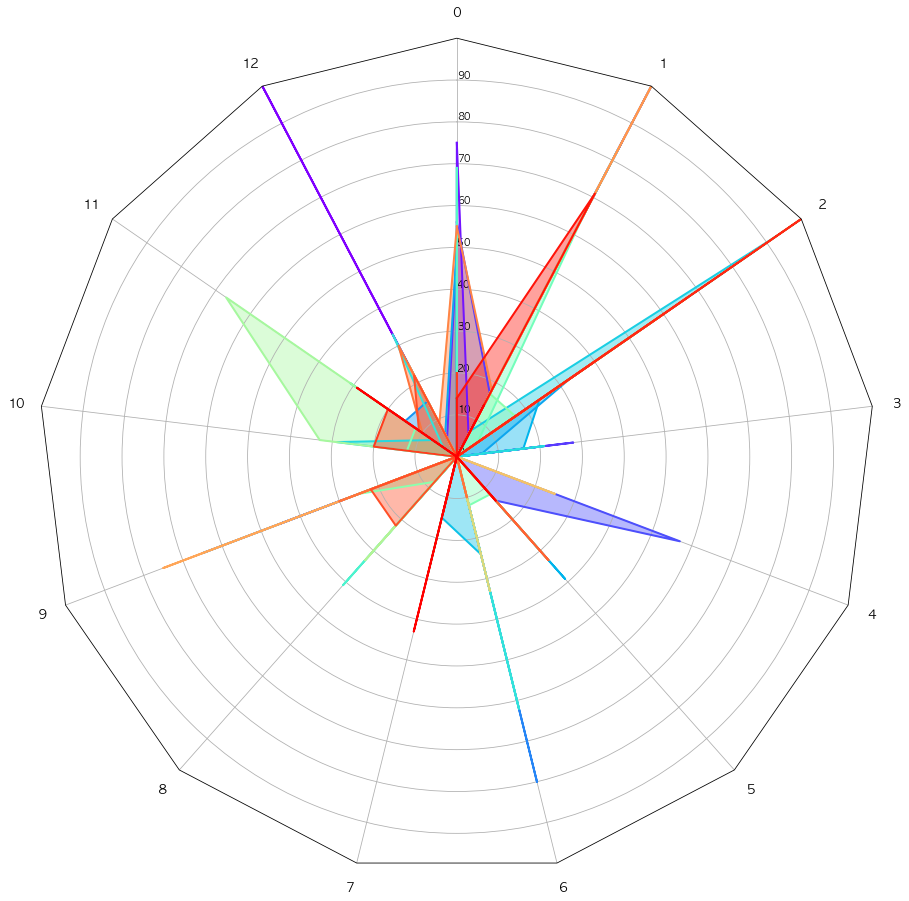

In [218]:
ms.visual_radar()

Mail Box Points Save Success.


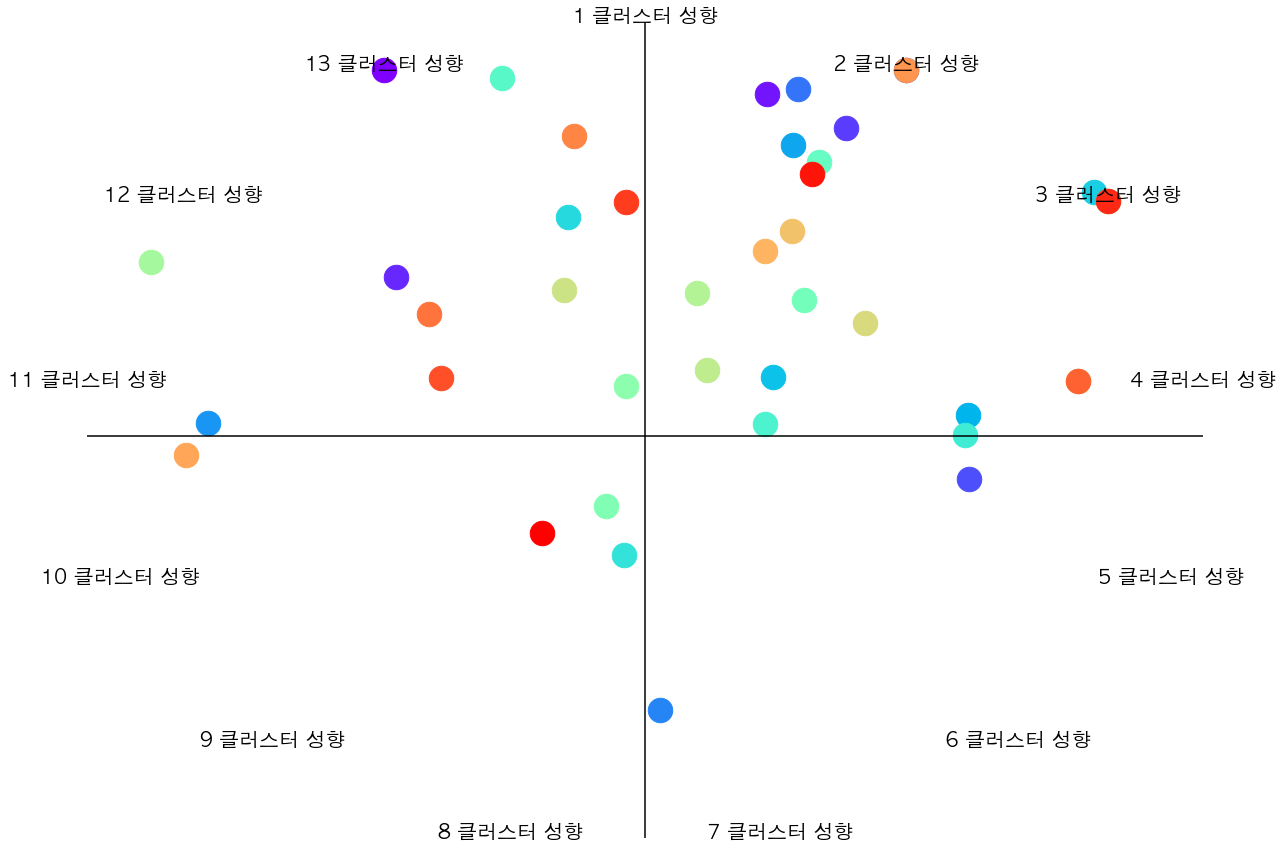

,x,y
623f2515ff1c441a392ab38c,-46.472317,88.545603
623f2515ff1c441a392ab38d,21.649808,82.602933
623f2515ff1c441a392ab38e,-44.399347,38.470060
623f2515ff1c441a392ab38f,35.696142,74.427779
623f2515ff1c441a392ab390,57.563993,-10.342338


In [219]:
ms.make_coord()
ms.visual_coord()

ms.mail_box_points.head()

# 유사도 확인

In [220]:
norm_features = ms.norm_features
mail_box_points = ms.mail_box_points
mail_box_col = ms.mail_box

norm_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
1,3UPjb91Fwm7u2tAm92Bk0p,0.450954,0.529227,0.636364,0.820022,0.035348,0.812049,0.000000,0.072191,0.219311,0.482922
2,3dbLT62Cvs46Ju7a8gpr36,0.686649,0.889710,0.818182,0.967201,0.264857,0.124570,0.000012,0.283056,0.698815,0.596867
3,2FWquqPNxte8iqZ3ATQG0p,0.245232,0.731424,0.727273,0.788933,0.564549,0.378857,0.000000,0.095386,0.434598,0.265127
4,3gzIK2dGSVvPBiohsTwEWZ,0.566757,0.573138,0.000000,0.746269,0.059170,0.058335,0.000177,0.114364,0.639013,0.570288


### 반경 내 유사도 측정

In [221]:
from bson import ObjectId

In [222]:
# query 예시

# 반경 50 내의 데이터만을 가지고 유사도 측정
rate =50
evaluate_pd_1 = pd.DataFrame()
for box_id in ms.mail_box_points.index.values:
    x, y = ms.mail_box_points.loc[box_id].values

    min_x = x - rate
    max_x = x + rate

    min_y = y - rate
    max_y = y + rate

    res = mail_box_col.find({
        "$and": [
            {"coord.x": { "$gte": min_x }},
            {"coord.x": { "$lte": max_x }},
            {"coord.y": { "$gte": min_y }},
            {"coord.y": { "$lte": max_y }},
        ]
    })

    track_info = pd.DataFrame()
    for _ in res:
        _id = str(_["_id"])
        track_list = _['tracks']

        _track_info = pd.DataFrame(track_list)
        _track_info['box_id'] = _id
        track_info = pd.concat([track_info, _track_info],ignore_index=True)

    track_info.head()

    my_track = track_info[track_info['box_id'] == box_id]['track_id']
    reco_track = track_info[track_info['box_id'] != box_id]['track_id']

    my_track.name = 'id'
    reco_track.name = 'id'

    my_track = pd.merge(my_track, norm_features, how='inner', on='id')
    reco_track = pd.merge(reco_track, norm_features, how='inner', on='id')

    euc_mean = euc(my_track.values[:,1:], reco_track.values[:, 1:]).mean()
    evaluate_pd_1 = evaluate_pd_1.append(pd.Series({
        "평균 거리": euc_mean
    }, name=box_id))
    
print("반경 내 테스트 : {}".format(evaluate_pd_1['평균 거리'].mean()))

반경 내 테스트 : 0.9503262670901799


### 반경 외 유사도 측정

In [223]:
# query 예시

# 반경 50 내의 데이터만을 가지고 유사도 측정
rate =50
evaluate_pd_2 = pd.DataFrame()
for box_id in ms.mail_box_points.index.values:
    x, y = ms.mail_box_points.loc[box_id].values

    min_x = x - rate
    max_x = x + rate

    min_y = y - rate
    max_y = y + rate

    res = mail_box_col.find({
        "$or": [
            {"_id": ObjectId(box_id)},
            {"$or": [
                {"coord.x": { "$lt": min_x }},
                {"coord.x": { "$gt": max_x }},
                {"coord.y": { "$lt": min_y }},
                {"coord.y": { "$gt": max_y }},
            ]}
        ]
    })

    track_info = pd.DataFrame()
    for _ in res:
        _id = str(_["_id"])
        track_list = _['tracks']

        _track_info = pd.DataFrame(track_list)
        _track_info['box_id'] = _id
        track_info = pd.concat([track_info, _track_info],ignore_index=True)

    track_info.head()

    my_track = track_info[track_info['box_id'] == box_id]['track_id']
    reco_track = track_info[track_info['box_id'] != box_id]['track_id']

    my_track.name = 'id'
    reco_track.name = 'id'

    my_track = pd.merge(my_track, norm_features, how='inner', on='id')
    reco_track = pd.merge(reco_track, norm_features, how='inner', on='id')
    
    euc_mean = euc(my_track.values[:,1:], reco_track.values[:, 1:]).mean()
    evaluate_pd_2 = evaluate_pd_2.append(pd.Series({
        "평균 거리": euc_mean
    }, name=box_id))
    
print("반경 외 테스트 : {}".format(evaluate_pd_2['평균 거리'].mean()))

반경 외 테스트 : 1.0935982775692277


In [240]:
evaluate_pd = pd.DataFrame(columns=['반경 내 테스트', '반경 외 테스트'])

evaluate_pd['반경 내 테스트'] = evaluate_pd_1['평균 거리']
evaluate_pd['반경 외 테스트'] = evaluate_pd_2['평균 거리']
evaluate_pd['오차'] = evaluate_pd['반경 내 테스트'] - evaluate_pd['반경 외 테스트']

print("반경 내, 반경 외 평균 오차는 {} 입니다.".format(evaluate_pd['오차'].mean()))

evaluate_pd.head()

반경 내, 반경 외 평균 오차는 -0.14327201047904758 입니다.


,반경 내 테스트,반경 외 테스트,오차
623f2515ff1c441a392ab38c,1.403210,1.548617,-0.145408
623f2515ff1c441a392ab38d,0.805091,1.009422,-0.204330
623f2515ff1c441a392ab38e,1.039137,1.294400,-0.255263
623f2515ff1c441a392ab38f,0.861158,1.020705,-0.159547
623f2515ff1c441a392ab390,0.996406,1.156575,-0.160169


In [226]:
check_idx = 4

rate_x = 50
rate_y = 50

_my_box_id = ms.mail_box_points.iloc[check_idx].name
user_centroid = ms.mail_box_points.iloc[check_idx].values
user_x, user_y = user_centroid

search_box = ms.mail_box_points[
    ((ms.mail_box_points['x'] < (user_x + rate_x)) & (ms.mail_box_points['x'] > (user_x - rate_x))) &
    ((ms.mail_box_points['y'] < (user_y + rate_y)) & (ms.mail_box_points['y'] > (user_y - rate_y)))
]

search_box

,x,y
623f2515ff1c441a392ab390,57.563993,-10.342338
623f2745ff1c441a392ab40a,57.381819,5.210545
623f2745ff1c441a392ab40b,22.775712,14.241739
623f2746ff1c441a392ab40f,56.856920,0.193728
623f2746ff1c441a392ab410,21.368019,2.826879
623f2746ff1c441a392ab413,28.204755,32.805717
623f2abbff1c441a392ab4c7,9.253405,34.624699
623f2abbff1c441a392ab4c8,11.050428,16.060476
623f2abcff1c441a392ab4ca,39.033869,27.284474
623f2abcff1c441a392ab4cb,77.022967,13.359483


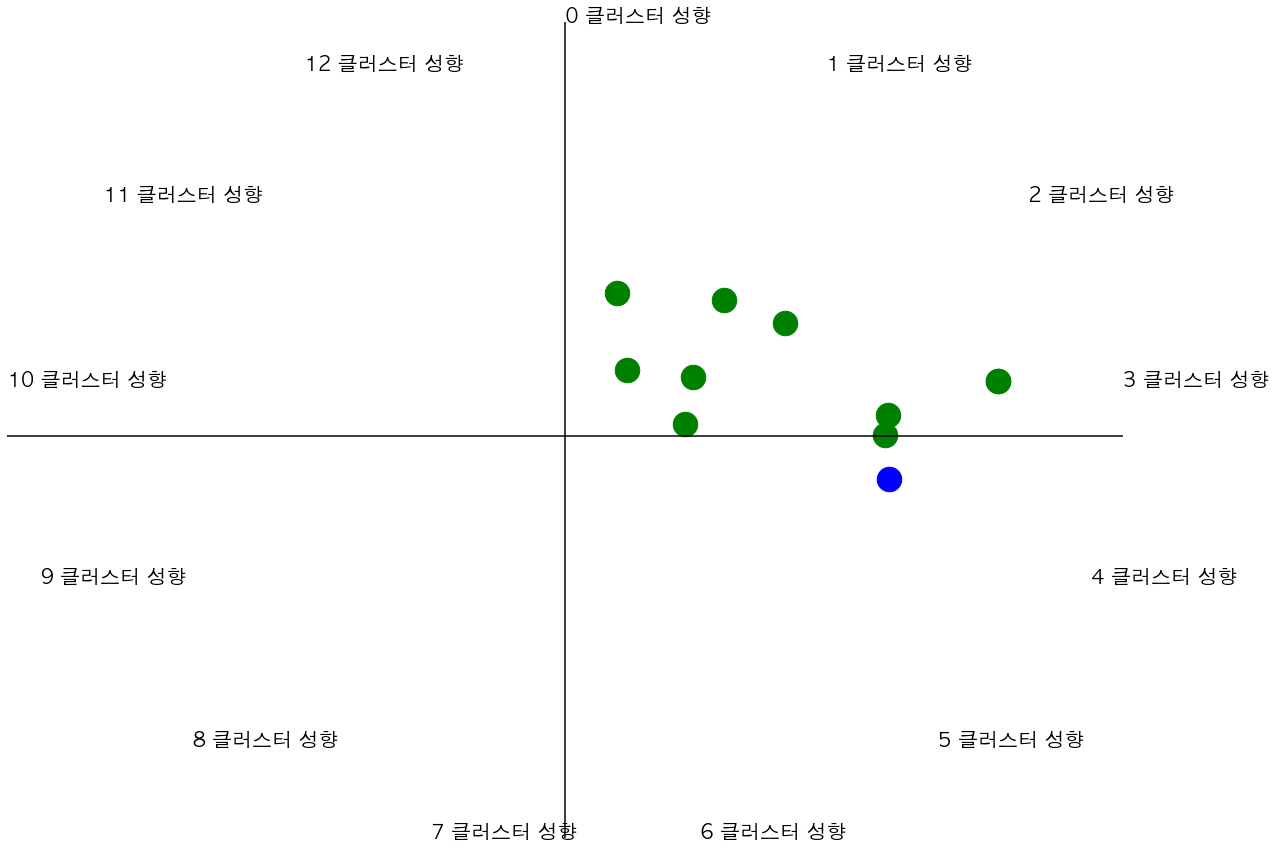

In [227]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=ms.mail_box_radar.index[idx])
    
for idx, pt in enumerate(ms.max_coord):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    ms.max_coord[:,0].min(),
    ms.max_coord[:,0].max()
])
plt.yticks([
    ms.max_coord[:,1].min(),
    ms.max_coord[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [228]:
tracks = pd.DataFrame()
reco_ids = list()

for box in ms.mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2515ff1c441a392ab390
1,2FWquqPNxte8iqZ3ATQG0p,All I Wanna Do (K) (Feat. Hoody & Loco),4XDi67ZENZcbfKnvMnTYsI,Jay Park,623f2515ff1c441a392ab390
2,343YBumqHu19cGoGARUTsd,Fake Love,3TVXtAsR1Inumwj472S9r4,Drake,623f2515ff1c441a392ab390
3,5Eg6N02CTSSbdthjVc7wLA,Don't Hurt Me,"0YinUQ50QDB7ZxSCLyQ40k,0hCNtLu0JehylgoiP8L4Gh,...","Mustard,Nicki Minaj,Jeremih",623f2515ff1c441a392ab390
4,2bxvKs7Q0zqFqajnRcgxbv,Cold Gangsta,6Ha4aES39QiVjR0L2lwuwq,Yo Gotti,623f2515ff1c441a392ab390


In [229]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2515ff1c441a392ab390,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
1,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2745ff1c441a392ab40b,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
2,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2746ff1c441a392ab413,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
3,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2abbff1c441a392ab4c7,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
4,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2abcff1c441a392ab4ca,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867


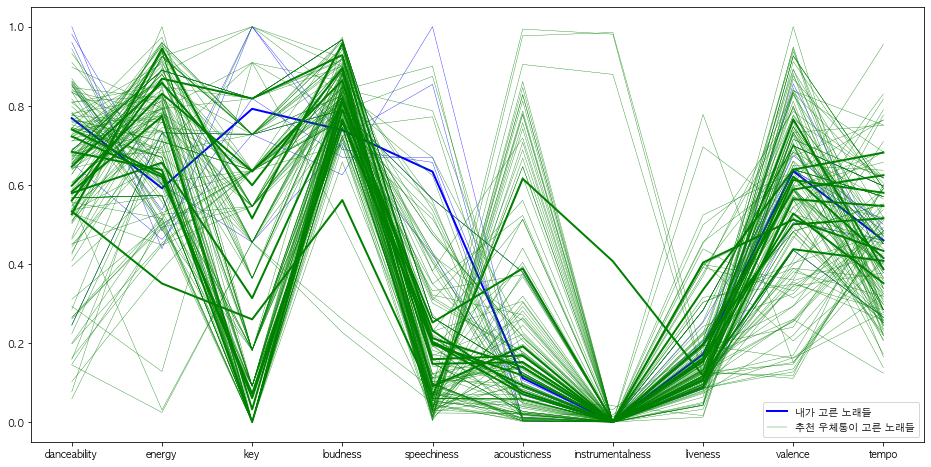

In [230]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [231]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 0.8935028234013983


In [232]:
rate_x = 50
rate_y = 50

_my_box_id = ms.mail_box_points.iloc[check_idx].name
user_centroid = ms.mail_box_points.iloc[check_idx].values
user_x, user_y = user_centroid

search_box = ms.mail_box_points[~(
    ((ms.mail_box_points['x'] < (user_x + rate_x)) & (ms.mail_box_points['x'] > (user_x - rate_x))) &
    ((ms.mail_box_points['y'] < (user_y + rate_y)) & (ms.mail_box_points['y'] > (user_y - rate_y)))
)]

search_box = search_box.append(ms.mail_box_points.iloc[check_idx])

search_box.head()

,x,y
623f2515ff1c441a392ab38c,-46.472317,88.545603
623f2515ff1c441a392ab38d,21.649808,82.602933
623f2515ff1c441a392ab38e,-44.399347,38.470060
623f2515ff1c441a392ab38f,35.696142,74.427779
623f2515ff1c441a392ab391,46.472317,88.545603


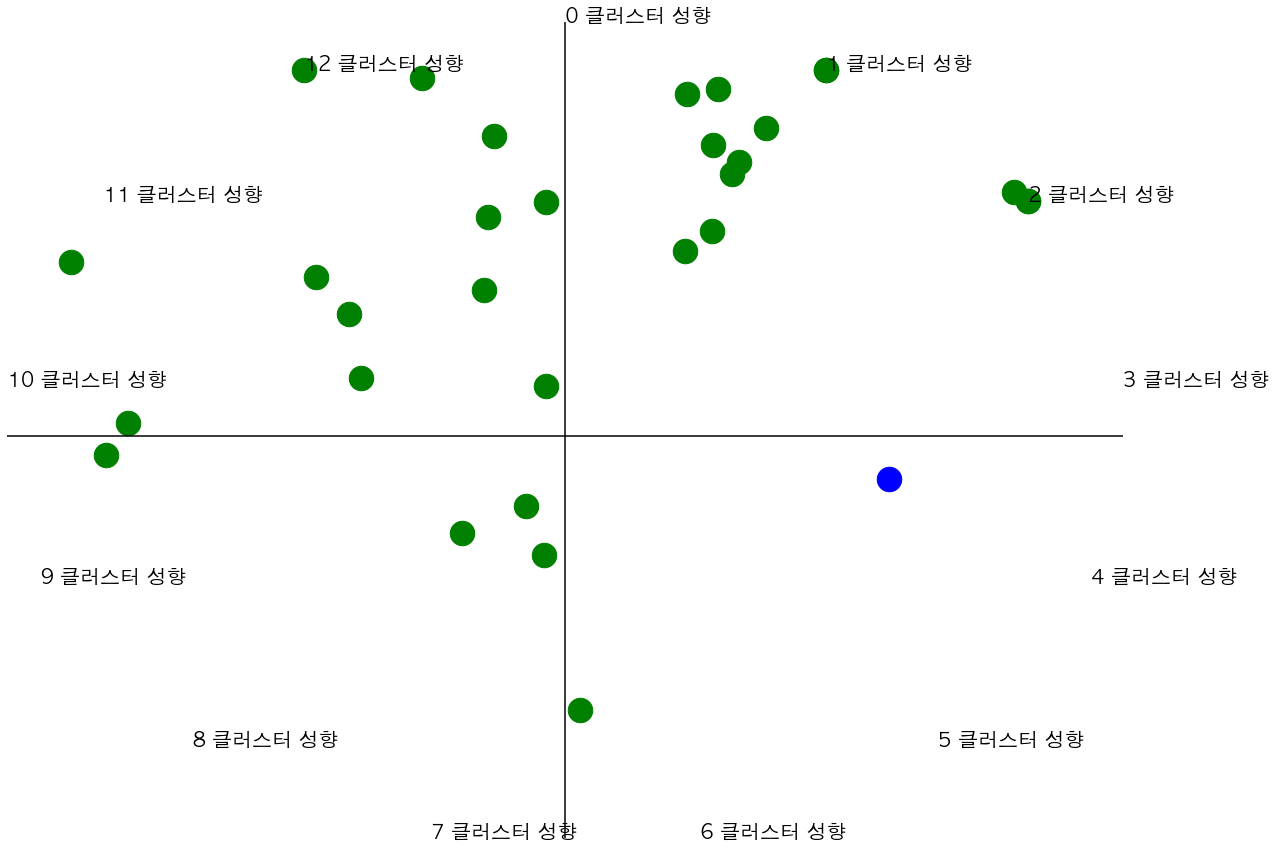

In [233]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=ms.mail_box_radar.index[idx])
    
for idx, pt in enumerate(ms.max_coord):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    ms.max_coord[:,0].min(),
    ms.max_coord[:,0].max()
])
plt.yticks([
    ms.max_coord[:,1].min(),
    ms.max_coord[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [234]:
tracks = pd.DataFrame()
reco_ids = list()

for box in ms.mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [235]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38e,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
2,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab394,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
3,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab395,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
4,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2746ff1c441a392ab40e,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436


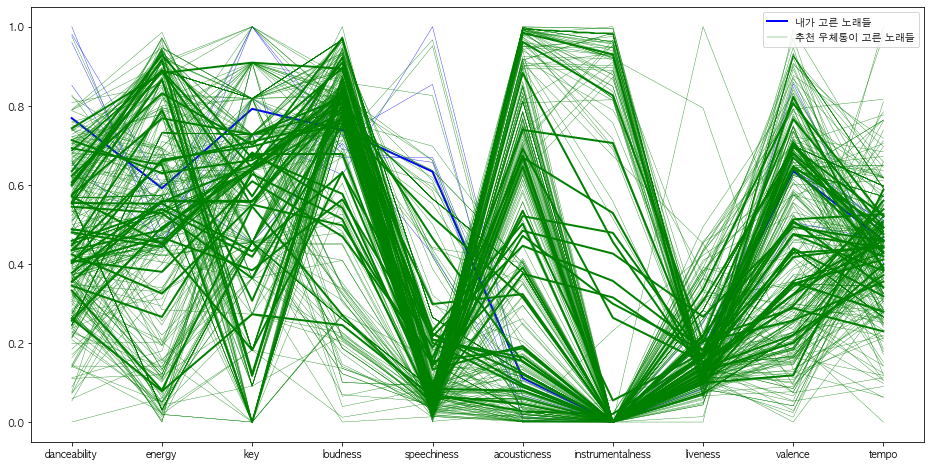

In [236]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [237]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.0640193926079429
